In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

## KNN on Titanic Survival Problem

## Define the problem

Goal: To predict the survival status of passengers on the Titanic based on features such as passenger class, sex, age, fare, and other relevant attributes 

### Load the data

We'll use the datasets provided by kaggle:[titanic/data](https://www.kaggle.com/c/titanic/data).

You can downloaded from here: [Titanic - all.zip](https://github.com/ProgressBG-Python-Course/JupyterNotebooksExamples/blob/master/datasets/Titanic/all.zip)

In [2]:
# load the dataset, using PassengerId as index
df_train = pd.read_csv("../../datasets/Titanic/train.csv", index_col='PassengerId')
df_test = pd.read_csv("../../datasets/Titanic/test.csv", index_col='PassengerId')

### Data variable descriptions:
<pre>
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5
</pre>

### Get insight of the data (Prepare and clean)

In [3]:
df_train.head(3)
# df_test.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
df_test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


#### Visualize with Seaborn

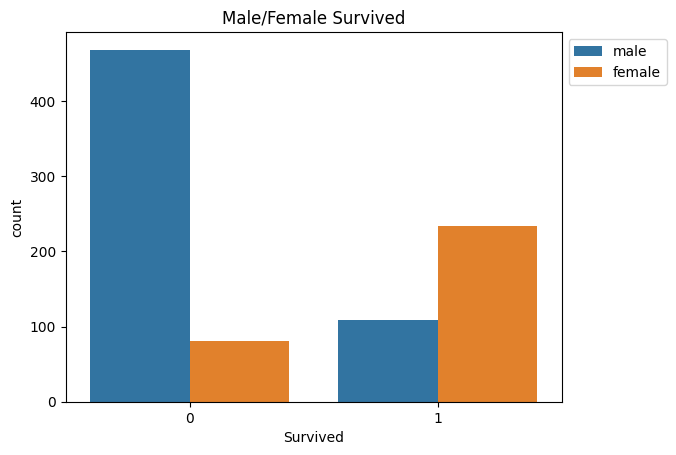

In [5]:
sns.countplot(data=df_train, x='Survived', hue='Sex')
plt.title("Male/Female Survived")
plt.legend(bbox_to_anchor=(1, 1), loc=2)

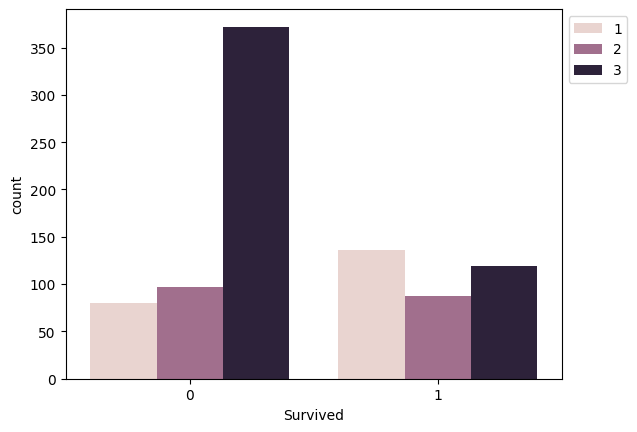

In [6]:
sns.countplot(data=df_train, x='Survived', hue='Pclass')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

<Axes: ylabel='Frequency'>

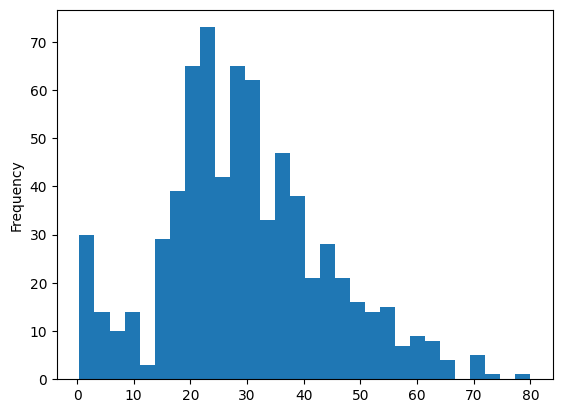

In [7]:
df_train['Age'].plot.hist(bins=30)

### Clean and wrangle the data

#### Check for NaN values

In [8]:
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Columns 'Age', 'Cabin' and 'Embarked' <span style="color:red">has NaN</span> values. We have to deal with them.

#### Deal with NaN values

In [9]:
def fill_nan_values(df):
    # Put port = Southampton for 'Embarked' null values:
    df["Embarked"] = df["Embarked"].fillna("S")

    # put the mean passengers age for 'Age' null values
    df["Age"] = df["Age"].fillna(df["Age"].median())

    # put 0 for cabin number for all 'Cabin' null values
    df["Cabin"] = df["Cabin"].fillna(0)

    # put the mean Fare for 'fare' null values:
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())

    return df


In [10]:
df_train = fill_nan_values(df_train)

In [11]:
# check again:
df_train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

#### Categorical text data => to numbers

In [12]:
# df_train.info()

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


We see that Name, Sex, Ticket, Cabin and Embarked columns are not numerical. We will have to convert them to numbers. But from analyses made before, we'll need only the Sex and Embarked features.

In [13]:
def categories_to_numbers(df):
    if df['Sex'].dtype == "object":
        # male => 1, female => 0
        df["Sex"] = np.where(df["Sex"] == "male", 1,0)

    if df['Embarked'].dtype == "object":
        ### this is just more-readable
        df.loc[df["Embarked"] == "S", "Embarked"] = 0
        df.loc[df["Embarked"] == "C", "Embarked"] = 1
        df.loc[df["Embarked"] == "Q", "Embarked"] = 2

        ### usefull, when we have more values
        # Get the unique values of Embarked
#         embarks = sorted(df['Embarked'].unique())

        # Generate a mapping of Embarked string to a numbers (0,1,...)
#         embarks_map = dict(zip(embarks, range(0, len(embarks) + 1)))

        # Transform Embarked from a string to a number representation
#         df['Embarked'] = df['Embarked'].map(embarks_map).astype(int)

    print("df['Sex'].dtype", df['Sex'].dtype)
    print("df['Embarked'].dtype", df['Embarked'].dtype)

    return df

In [14]:
df_train = categories_to_numbers(df_train)

df_train.head()

df['Sex'].dtype int64
df['Embarked'].dtype object


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0


## Select features

### Show Correlations

In [15]:
# show correlations
df_train_corr = df_train.corr()
sns.heatmap(df_train_corr,annot=True, cmap="Reds")

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

From the heat map we can see that 'Sex', 'Pclass','Fare' and 'Embarked' have the highest weight for 'Survived'. And we will use them as features.


<!-- ### Drop columns we won't use -->

In [ ]:
usefull_features = ['Sex', 'Pclass','Survived']

df_train = df_train[ usefull_features ]
df_train.shape

(891, 3)

## Separate the training data from the test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop('Survived',axis=1),
    df_train['Survived'],
    random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (668, 2)
X_test shape: (223, 2)
y_train shape: (668,)
y_test shape: (223,)


## Choose the model

Looking at our data, we can see, that there is clearly separated 3 classes. So, we'll start with most simple algorithm for Classification - the k-Neareast Neighbour (kNN).

In [ ]:
# Import the sklearn class for the algorithm we decided to use
from sklearn.neighbors import KNeighborsClassifier

## Train the model (fit the model)


In [ ]:
# instantiate and fit the model
# the default value for k is 5, we will choose 3
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

## Predict (classify unknown input sample)

In [ ]:
y_pred = knn.predict(X_test)

## Evaluate the model

In [ ]:
# by hand - calc wrong answers
(y_pred != y_test).sum()

55

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       134
           1       0.70      0.67      0.69        89

    accuracy                           0.75       223
   macro avg       0.74      0.74      0.74       223
weighted avg       0.75      0.75      0.75       223



In [ ]:
X_train

,Sex,Pclass
PassengerId,,
299,1,1
885,1,3
248,0,2
479,1,3
306,1,1
...,...,...
107,0,3
271,1,1
861,1,3


Text(0.5, 1.0, 'Knn bounderies')

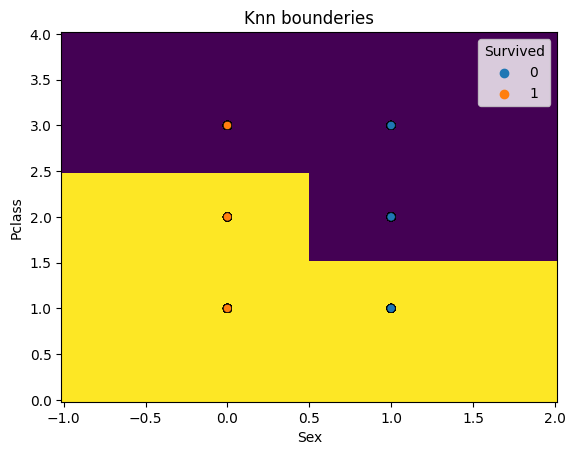

In [ ]:
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
	knn,
	X_train,
	ax=ax,
	response_method="predict",
	plot_method="pcolormesh",
	xlabel=X_train.columns[0],
	ylabel=X_train.columns[1],
	shading="auto",
)

# Plot also the training points
sns.scatterplot(
	x=X_train['Sex'],
	y=X_train['Pclass'],
	hue=y_train,
	alpha=1.0,
	edgecolor="black",
)
plt.title(
	"Knn bounderies"
)